<a href="https://colab.research.google.com/github/ORIE5355/project_competition_public/blob/main/run_gym_headtohead.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import time
from IPython import display

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import make_env

In [4]:
project_part = 2 #TODO Change this for whether you're coding for part 1 or part 2!
agentnames = ['agent_coop_ex_ms', 'agent_coop_ex_custom_single_alpha']

In [6]:
if project_part == 1:
    env, agents = make_env.make_env_agents(agentnames = agentnames, project_part = project_part)
    
else:
    env, agents = make_env.make_env_agents(agentnames = agentnames, project_part = project_part
    , first_file = 'data/datafile1.csv', second_file='data/datafile2.csv')

# you can replace the agentnames to match whatever agentfiles you create. 
# you can use the same agentnames for both agents

In [7]:
T = 500

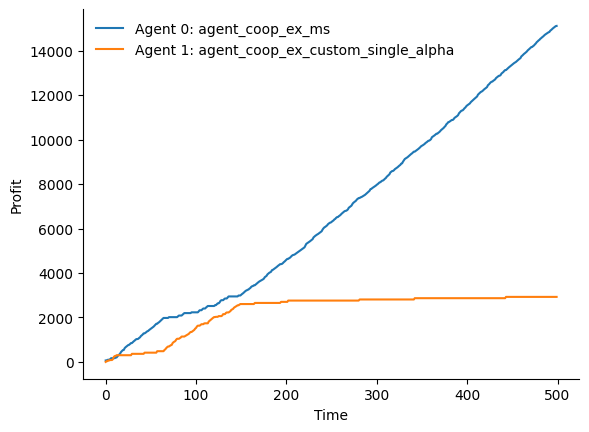

last customer covariate:  [0.28869078 6.30018922 4.40015701]
last (item bought, agent bought from, prices):  (0, 0, [[10.283567004468425, 28.094447943824665], [11.077856486051513, 30.244778650830106]])
current_profit per agent:  [15111.055524619163, 2924.6280629947846]
Cumulative buyer utility: 11115.097998392419
Average per-customer runtime agent 0 in seconds: 0.053030375480651856
Average per-customer runtime agent 1 in seconds: 0.05186663150787354


In [8]:
env.reset()
customer_covariates, sale, profits = env.get_current_state_customer_to_send_agents()
last_customer_covariates = customer_covariates
cumulativetimes = [0 for _ in agents]

fig, ax = plt.subplots(figsize=(20, 10))
for t in range(0, T):
    actions = []
    for enoutside, agent in enumerate(agents):
      ts = time.time()
      action = agent.action((customer_covariates, sale, profits))
      assert len(action) == project_part ## Have to give 1 price for each item. There is 1 item in part 1, 2 items in part 2
      curtime = time.time()
      cumulativetimes[enoutside] += curtime - ts
      actions.append(action)
    customer_covariates, sale, profits = env.step(actions)
    newplot = env.render(True)
    if newplot:
      display.clear_output(wait=True)
      display.display(plt.gcf())
    print('last customer covariate: ', last_customer_covariates)
    print('last (item bought, agent bought from, prices): ', sale)
    print('current_profit per agent: ', profits)
    last_customer_covariates = customer_covariates
plt.close()
print("Cumulative buyer utility: {}".format(env.cumulative_buyer_utility))
print("Average per-customer runtime agent 0 in seconds: {}".format(cumulativetimes[0]/T))
print("Average per-customer runtime agent 1 in seconds: {}".format(cumulativetimes[1]/T))

In [20]:
def run_h2h(agentnames, T=500, num_runs=1, make_graphs=True):
    
    profits_cum = np.zeros((2,num_runs))
    times = np.zeros((2, num_runs, T))
    
    if make_graphs:
        plt.rcParams.update({'font.size': 36})
        # Adjust rows and columns for at most two graphs per row
        cols = 2 if num_runs > 1 else 1
        rows = (num_runs + 1) // 2  # Calculate the number of rows needed
        fig, axes = plt.subplots(rows, cols, figsize=(20 * cols, 10 * rows))
        if rows == 1:
            axes = [axes]
    
    for i in range(num_runs):
        # Load them
        if project_part == 1:
            env, agents = make_env.make_env_agents(agentnames = agentnames, project_part = project_part)
        else:
            env, agents = make_env.make_env_agents(agentnames = agentnames, project_part = project_part
            , first_file = 'data/datafile1.csv', second_file='data/datafile2.csv')
        # do h2h
        env.reset()
        customer_covariates, sale, profits = env.get_current_state_customer_to_send_agents()
        last_customer_covariates = customer_covariates
        
        if make_graphs:
            run_profits = []
        for t in range(0, T):
            actions = []
            for enoutside, agent in enumerate(agents):
              start = time.time()
              action = agent.action((customer_covariates, sale, profits))
              total = (time.time() - start) * 1000
              times[enoutside, i, t] = total
              assert len(action) == project_part ## Have to give 1 price for each item. There is 1 item in part 1, 2 items in part 2
              actions.append(action)
            customer_covariates, sale, profits = env.step(actions)
            last_customer_covariates = customer_covariates
            if make_graphs:
                run_profits.append(profits.copy())
            if t == T-1:
                profits_cum[0, i] = profits[0]
                profits_cum[1, i] = profits[1]
        if make_graphs:        
            ax = axes[i] if num_runs == 1 else axes[i // cols][i % cols]
            ax.plot([p[0] for p in run_profits], label=agentnames[0], linewidth=3)  # Plot for agent 0
            ax.plot([p[1] for p in run_profits], label=agentnames[1], linewidth=3)  # Plot for agent 1
            ax.set_title(f"Run {i + 1}", fontsize=42) 
            ax.set_xlabel("Timestep")
            ax.set_ylabel("Profit")
            ax.legend()
    
    print(f"{'Agent Name':<40} | {'Average Profit':>15} | {'Profit Variance':>15} | {'Min Profit':>10} | {'Max Profit':>10} | {'Total Profit':>10} |  {'Time Per Cust (ms 1000s)':>10}")
    print('-'*130)
    for i in range(len(agentnames)):
        average_profit = np.mean(profits_cum[i, :])
        profit_variance = np.var(profits_cum[i, :])
        min_profit = np.min(profits_cum[i, :])
        max_profit = np.max(profits_cum[i, :])
        tot_profit = np.sum(profits_cum[i, :])
        avg_time = np.mean(times[i, :, :])

        print(f"{agentnames[i]:<40} | {average_profit:>15.2f} | {profit_variance:>15.2f} | {min_profit:>10.2f} | {max_profit:>10.2f} | {tot_profit:>10.2f} | {avg_time:>10.4f}")
    if make_graphs:
        plt.tight_layout()
        plt.show()

In [14]:
def run_multiple_groups(groups, num_runs=100):
    for group in groups:
        run_h2h(group, num_runs=num_runs, make_graphs=False)
        print("\n")

In [15]:
agentnames = ['agent_coop_ex_ms', 'agent_coop_ex_custom_single_alpha']
run_h2h(agentnames, num_runs=1, make_graphs=False)

[autoreload of  failed: Traceback (most recent call last):
  File "C:\Users\User\anaconda3\Lib\site-packages\IPython\extensions\autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\User\anaconda3\Lib\site-packages\IPython\extensions\autoreload.py", line 475, in superreload
    module = reload(module)
             ^^^^^^^^^^^^^^
  File "C:\Users\User\anaconda3\Lib\importlib\__init__.py", line 168, in reload
    raise ModuleNotFoundError(f"spec not found for the module {name!r}", name=name)
ModuleNotFoundError: spec not found for the module ''
]


Agent Name                               |  Average Profit | Profit Variance | Min Profit | Max Profit | Total Profit |  Time Per Cust (ms)
---------------------------------------------------------------------------------------------------------------------
agent_coop_ex_ms                         |        15600.01 |            0.00 |   15600.01 |   15600.01 |   15600.01 |    42.1096
agent_coop_ex_custom_single_alpha        |         2073.29 |            0.00 |    2073.29 |    2073.29 |    2073.29 |    42.0105


In [16]:
agentnames = ['ab-diffalphas_coop_ex_ms', 'ab-multi_coop_exploit_ms']
run_h2h(agentnames, num_runs=1, make_graphs=False)

Agent Name                               |  Average Profit | Profit Variance | Min Profit | Max Profit | Total Profit |  Time Per Cust (ms)
---------------------------------------------------------------------------------------------------------------------
ab-diffalphas_coop_ex_ms                 |         4250.40 |            0.00 |    4250.40 |    4250.40 |    4250.40 |    59.8488
ab-multi_coop_exploit_ms                 |        13755.64 |            0.00 |   13755.64 |   13755.64 |   13755.64 |    59.2838


In [17]:
agentnames = ['dummy_fixed_prices_adaptive', 'agent_coop_ex_ms_reset-pt5-to-pt75']
run_h2h(agentnames, num_runs=1, make_graphs=False)

Agent Name                               |  Average Profit | Profit Variance | Min Profit | Max Profit | Total Profit |  Time Per Cust (ms)
---------------------------------------------------------------------------------------------------------------------
dummy_fixed_prices_adaptive              |         1508.76 |            0.00 |    1508.76 |    1508.76 |    1508.76 |     0.0380
agent_coop_ex_ms_reset-pt5-to-pt75       |            0.00 |            0.00 |       0.00 |       0.00 |       0.00 |    47.0530


In [18]:
agentnames = ['dummy_max_val', 'agent_at_pred']
run_h2h(agentnames, num_runs=1, make_graphs=False)

Agent Name                               |  Average Profit | Profit Variance | Min Profit | Max Profit | Total Profit |  Time Per Cust (ms)
---------------------------------------------------------------------------------------------------------------------
dummy_max_val                            |            0.00 |            0.00 |       0.00 |       0.00 |       0.00 |     0.0040
agent_at_pred                            |        23500.58 |            0.00 |   23500.58 |   23500.58 |   23500.58 |    40.6682


In [21]:
agentnames = ['ab-ex_coop_exploit_ms', 'ab-ms_coop_exploit_ms']
run_h2h(agentnames, num_runs=1, make_graphs=False)

Agent Name                               |  Average Profit | Profit Variance | Min Profit | Max Profit | Total Profit |  Time Per Cust (ms 1000s)
----------------------------------------------------------------------------------------------------------------------------------
ab-ex_coop_exploit_ms                    |        10542.08 |            0.00 |   10542.08 |   10542.08 |   10542.08 |    40.6188
ab-ms_coop_exploit_ms                    |         4465.08 |            0.00 |    4465.08 |    4465.08 |    4465.08 |    40.0261


In [22]:
agentnames = ['ads_annihilators', 'agent_at_pred']
run_h2h(agentnames, num_runs=1, make_graphs=False)

Agent Name                               |  Average Profit | Profit Variance | Min Profit | Max Profit | Total Profit |  Time Per Cust (ms 1000s)
----------------------------------------------------------------------------------------------------------------------------------
ads_annihilators                         |        15912.49 |            0.00 |   15912.49 |   15912.49 |   15912.49 |    40.6211
agent_at_pred                            |         7071.44 |            0.00 |    7071.44 |    7071.44 |    7071.44 |    40.5448


In [23]:
agentnames = ['agent_coop_ex_custom_ms', 'agent_coop_ex_custom_single_alpha_ms']
run_h2h(agentnames, num_runs=1, make_graphs=False)

Agent Name                               |  Average Profit | Profit Variance | Min Profit | Max Profit | Total Profit |  Time Per Cust (ms 1000s)
----------------------------------------------------------------------------------------------------------------------------------
agent_coop_ex_custom_ms                  |         8169.65 |            0.00 |    8169.65 |    8169.65 |    8169.65 |    39.5301
agent_coop_ex_custom_single_alpha_ms     |        11713.61 |            0.00 |   11713.61 |   11713.61 |   11713.61 |    39.8282


In [ ]:
agentnames = ['agent_coop_ex_custom_single_alpha', 'agent_coop_ex_custom']
run_h2h(agentnames, num_runs=1, make_graphs=False)

In [ ]:
agentnames = ['agent_coop_ex_ms_reset-pt5-to-pt75', 'agent_coop_ex_ms']
run_h2h(agentnames, num_runs=1, make_graphs=False)

In [ ]:
agentnames = ['agent_coop_ex_ms40', 'agent_coop_ex30_ms']
run_h2h(agentnames, num_runs=1, make_graphs=False)

In [ ]:
agentnames = ['dummy', 'dummy_fixed_prices']
run_h2h(agentnames, num_runs=1, make_graphs=False)